# DTSA-5510 Week 4 Programming Assignment: BBC News Classification
## May 23, 2022

## Introduction

This is the Week 3 project for DTSA-5510, Unsupervised Algorithms in Machine Learning, and performs unsupervised learning algorithms to [BBC news stories](https://www.kaggle.com/competitions/learn-ai-bbc/overview) from a machine learning competition on [Kaggle](https://www.kaggle.com).
  
This project attempts to categorize or cluster BBC news stories based on the textual content of the story. After binning the stories, the bins are assigned the category names based on the highest predictive score and then these names are compared to the test data to determine the accuracy of the unsupervised learning method.

This Jupyter notebook along with the data used to create report can be found at and cloned from https://github.com/clayv/DTSA-5510_Week_4.

In [1]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics 

#Set a global random state (set to 'None' if reproducible results are not desired)
randomState = 42

## Step 0: Load the data

In [2]:
df_train = pd.read_csv("data/BBC News Train.csv.zip", compression="zip")
df_test = pd.read_csv("data/BBC News Test.csv.zip", compression="zip")
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA)
The data appeared well maintained already with no null values in either of the training or testing data sets.

All the training data is therefore classified (in the Category) column and a call to unique() will tell us the Category names.

In [3]:
topics = df_train["Category"].unique()

print(topics.tolist())
print()
print(df_train.info())
print()
print(df_test.info())

['business', 'tech', 'politics', 'sport', 'entertainment']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


In [4]:
#df_train["Category"] = df_train["Category"].astype("category")


### Histograms and Data Cleaning
To get a better idea of the content of each category, a histogram of each categories top 20 words is plotted. Some common terms such as "new", "said", and "year" were intially cleaned from the data set in the cleanDataset function. But you'll notice those lines are now commented out as it was discovered leaving them in and then adjusting the maxDf hyperparameter (more on that later) gave a higher accuracy.

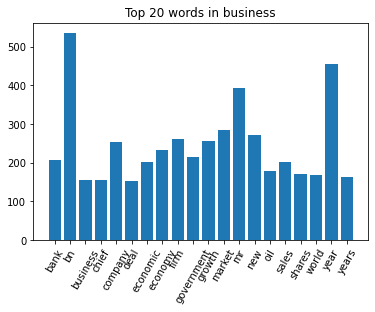

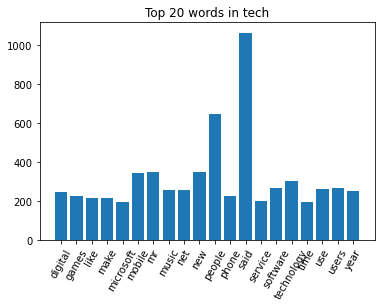

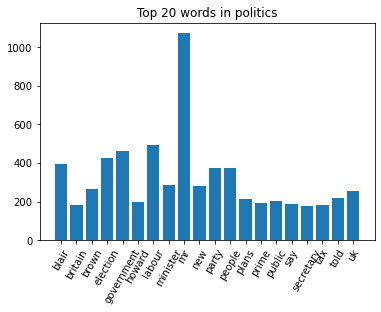

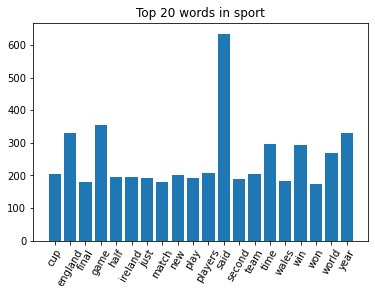

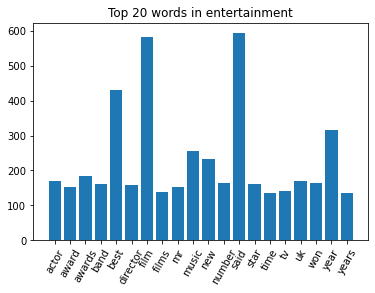

In [9]:
n_topWords = 20
    
def replaceInDataframe(df, replace, to):
    df.replace(to_replace = replace, value = to, inplace = True, regex = True)

def cleanDataset(df):
    replaceInDataframe(df, "’", "\'")
#    replaceInDataframe(df, "\\s+mr\\s+", "")
#    replaceInDataframe(df, "\\s+new\\s+", "")
#    replaceInDataframe(df, "\\s+said", "")
#    replaceInDataframe(df, "\\s+year", "")
    replaceInDataframe(df, "\\d+", "")

def plotTopicHistogram(topic):
    temp_df = df_train.loc[df_train["Category"] == topic]["Text"]
    tf = tf_vectorizer.fit_transform(temp_df)
    plt.title("Top {} words in {}".format(n_topWords, topic))
    plt.bar(x = tf_vectorizer.get_feature_names_out(), height = np.sum(tf.toarray(), axis=0))
    plt.xticks(rotation = 60)
    plt.show()       
    
tf_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = n_topWords, stop_words = "english")
for topic in topics:
    plotTopicHistogram(topic)

#Clean the data!    
cleanDataset(df_train)
cleanDataset(df_test)


In [20]:
# Helper functions

def makeLabelDict(labels):
    workingDict = {}
    for i in range(len(labels)):
        workingDict[i] = labels[i]
    return workingDict        

def label_permute_compare(ytdf, yp, labelDict):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    permutations = list(itertools.permutations(range(len(labelDict))))
    order = []
    highAcc = 0
    length = len(yp)
    for permutation in permutations:
        mapping = np.empty(length, dtype = object)
        for i in range(length):
            mapping[i] = labelDict[permutation[yp[i]]]
        acc = metrics.accuracy_score(ytdf, mapping)
        if acc > highAcc:
            highAcc = acc
            order = permutation
    return order, highAcc       

def fitNMF(tfidf, n_topicLabels, alpha, lossFunc, solverArg):
    #print("Fitting the NMF model with {} loss function and solver {}".format(lossFunc, solverArg))
    nmf = NMF(
        n_components = n_topicLabels,
        random_state = randomState,
        init = "nndsvda",
        beta_loss = lossFunc,
        solver = solverArg,
        max_iter = 1000,
        alpha_W = alpha,
        alpha_H = alpha,
        l1_ratio = 0.5,
    ).fit(tfidf)
    return nmf

def predictions(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

def outputModel(model, labelMap, labelDict):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print()
    for topic_idx, topic in enumerate(model.components_):
        print("Label: {}".format(labelDict[labelMap[topic_idx]]))
        print(" ".join([feature_names[i]
            for i in topic.argsort()[:-n_topWords - 1:-1]]))
        print()


## Step 2: Building and Training Models
I chose Non-Negative Matrix Factorization as my factorization method for the unsupervised learning approach. When training this model I used both the training and testing data sets because in an unsupervised clustering model, it is impossible to "overfit" the model to the testing data as the actual classification are not exposed to the modeling algorithm, not even for the training data. The algorithm is merely told how many clusters to create and matching those clusters to classifications for accuracy comes after the algorithm has been run.

The accuracy on the training data using this technique was $\approx$ 0.948 and Kaggle reported the accuracy on the testing data as $\approx$ 0.932.  This accuracy level was achieved after some experimentation with the parameters to the TfidfVectorizer and essentially _not_ cleaning the data sets.

Initially, the data sets were cleaned of words that occurred frequently (see histograms above) such as "new", "said", and "year" and the max_df of the TfidfVectorizer was set to 0.95.  But I found that leaving the frequent words in the data set and lowering the max_df to 0.90 increase the accuracy on the training data from 0.943 to 0.948.

In [21]:
topicDict = makeLabelDict(topics)
n_topics = len(topics)
n_maxFeatures = n_topics * n_topWords * 10 # 5 x 20 x 10 = 1000

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = n_maxFeatures, stop_words = "english")

tfidf_all = tfidf_vectorizer.fit_transform(pd.concat([df_train["Text"], df_test["Text"]], ignore_index = True))
nmfModel = fitNMF(tfidf_all, n_topics, "kullback-leibler", "mu")

predictedTopics = predictions(nmfModel.transform(tfidf_all))
labelOrder, acc = label_permute_compare(df_train["Category"], predictedTopics[:len(df_train)], topicDict)
print("Got accuracy of: {}".format(acc))

pred = []
for i in range(len(df_train)):
    pred.append(topicDict[labelOrder[predictedTopics[i]]])
print("Confusion Matrix:")
print(metrics.confusion_matrix(df_train["Category"], pred))

outputModel(nmfModel, labelOrder, topicDict)

testPredictions = []
for i in predictedTopics[len(df_train):]:
    testPredictions.append(topicDict[labelOrder[i]])
data = {'ArticleId':df_test.ArticleId, 'Category':testPredictions}
df = pd.DataFrame(data)
try:
    df.to_csv("C:\\Users\\clayv\Desktop\\BBCNews.csv", index = False)
except:
    pass
#print("TF-IDF Vectorizer trained with only training dataset got accuracy score on test dataset of: 0.38911")
print("TF-IDF Vectorizer trained with with both training and test dataset got accuracy score on test dataset of: 0.93197")

Extracting tf-idf features for NMF...
Got accuracy of: 0.9476510067114094
Confusion Matrix:
[[313   0  14   1   8]
 [  1 258   9   1   4]
 [  7   0 265   0   2]
 [  1   3  11 331   0]
 [  4   4   6   2 245]]

Label: politics
mr said labour government election blair party brown people minister law public howard eu told prime court police plans tax

Label: sport
game england win club said team match cup play world players injury ireland time season final wales year chelsea half

Label: business
bn said company growth market year bank firm economy sales shares oil china economic prices deal financial india business rise

Label: entertainment
film best music awards award star band tv year films album actor festival singer said director oscar won prize number

Label: tech
people mobile technology said software users phone digital computer use online games net internet music microsoft video service information broadband

TF-IDF Vectorizer trained with with both training and test dataset got 

### Trying different hyperparameters
When trying different hyperparameters, I was unable to find a combination that gave a higher accuracy.  A table of the parameters tried is below and this is after the aforementioned tuning of the TfidfVectorizer and "uncleaning" the data.

In [37]:
lossFuncs = ["frobenius", "kullback-leibler", "itakura-saito"]
solvers = ["cd", "mu"]
alphas = np.arange(0.0, 0.00010, 0.00001)
maxAcc = 0
print("Loss Function\tSolver\tAlpha\t\t\t\tAccuracy")
for lossFunc in lossFuncs:
    for solver in solvers:
        for alpha in alphas:
            try:
                nmfModel = fitNMF(tfidf_all, n_topics, lossFunc, solver)
                predictedTopics = predictions(nmfModel.transform(tfidf_all))
                labelOrder, acc = label_permute_compare(df_train["Category"], predictedTopics[:len(df_train)], topicDict)
                print("{}\t{}\t{}\t\t\t\t{}".format(lossFunc, solver, alpha, acc))
                if acc > maxAcc:
                    bestLossFunc, bestSolver, bestAlpha, maxAcc = lossFunc, solver, alpha, acc
            except:
                pass
print()
print("Highest accuracy was: {} with {}, {} and alpha: {}".format(maxAcc, bestLossFunc, bestSolver, bestAlpha))    


Loss Function	Solver	Alpha				Accuracy
frobenius	cd	0.0				0.8906040268456376
frobenius	cd	1e-05				0.8906040268456376
frobenius	cd	2e-05				0.8906040268456376
frobenius	cd	3.0000000000000004e-05				0.8906040268456376
frobenius	cd	4e-05				0.8906040268456376
frobenius	cd	5e-05				0.8906040268456376
frobenius	cd	6.000000000000001e-05				0.8906040268456376
frobenius	cd	7.000000000000001e-05				0.8906040268456376
frobenius	cd	8e-05				0.8906040268456376
frobenius	cd	9e-05				0.8906040268456376
frobenius	mu	0.0				0.8986577181208054
frobenius	mu	1e-05				0.8986577181208054
frobenius	mu	2e-05				0.8986577181208054
frobenius	mu	3.0000000000000004e-05				0.8986577181208054
frobenius	mu	4e-05				0.8986577181208054
frobenius	mu	5e-05				0.8986577181208054
frobenius	mu	6.000000000000001e-05				0.8986577181208054
frobenius	mu	7.000000000000001e-05				0.8986577181208054
frobenius	mu	8e-05				0.8986577181208054
frobenius	mu	9e-05				0.8986577181208054
kullback-leibler	mu	0.0				0.9476510067114094
k